# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


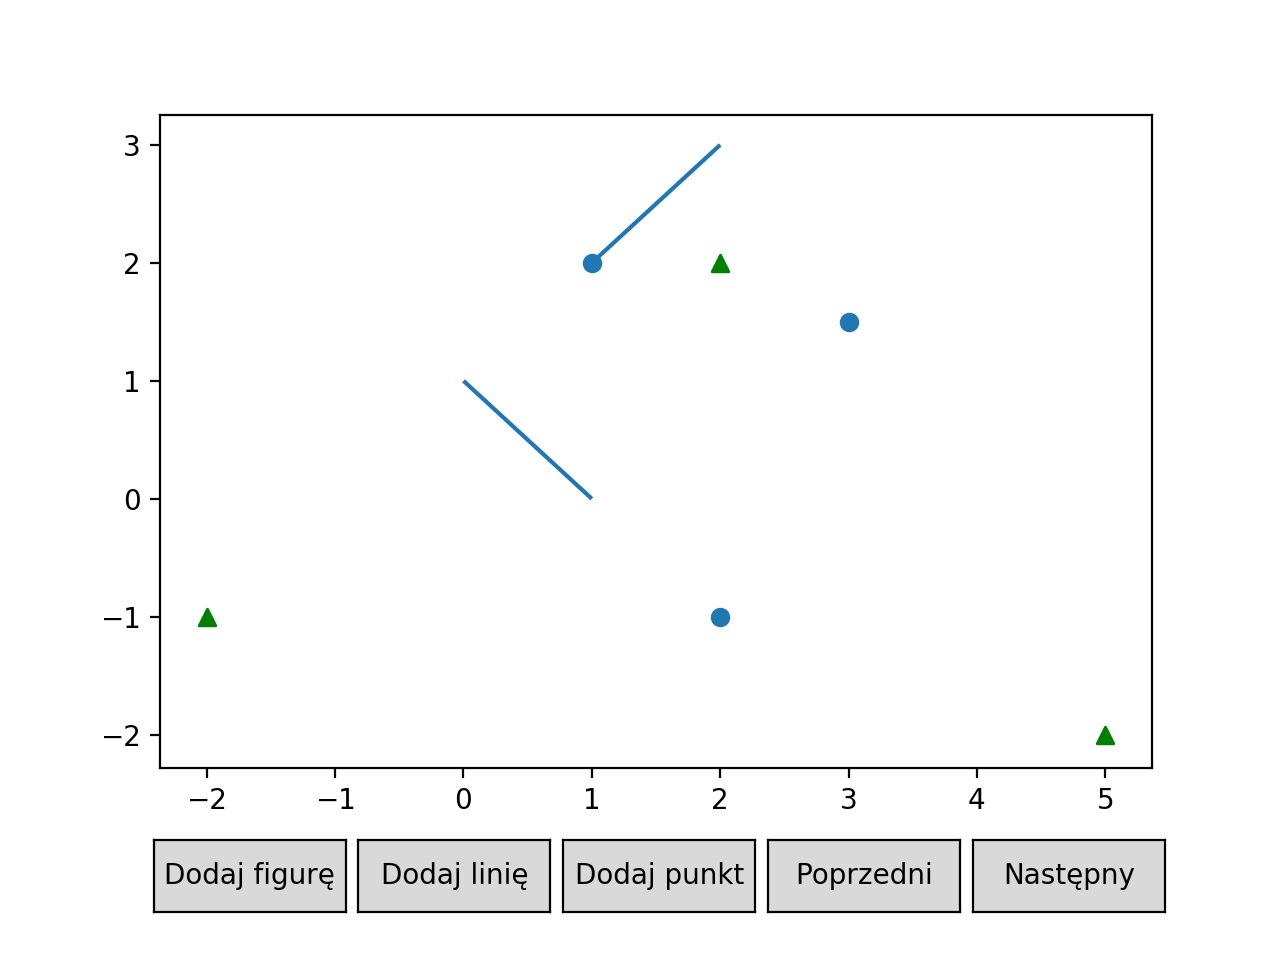

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


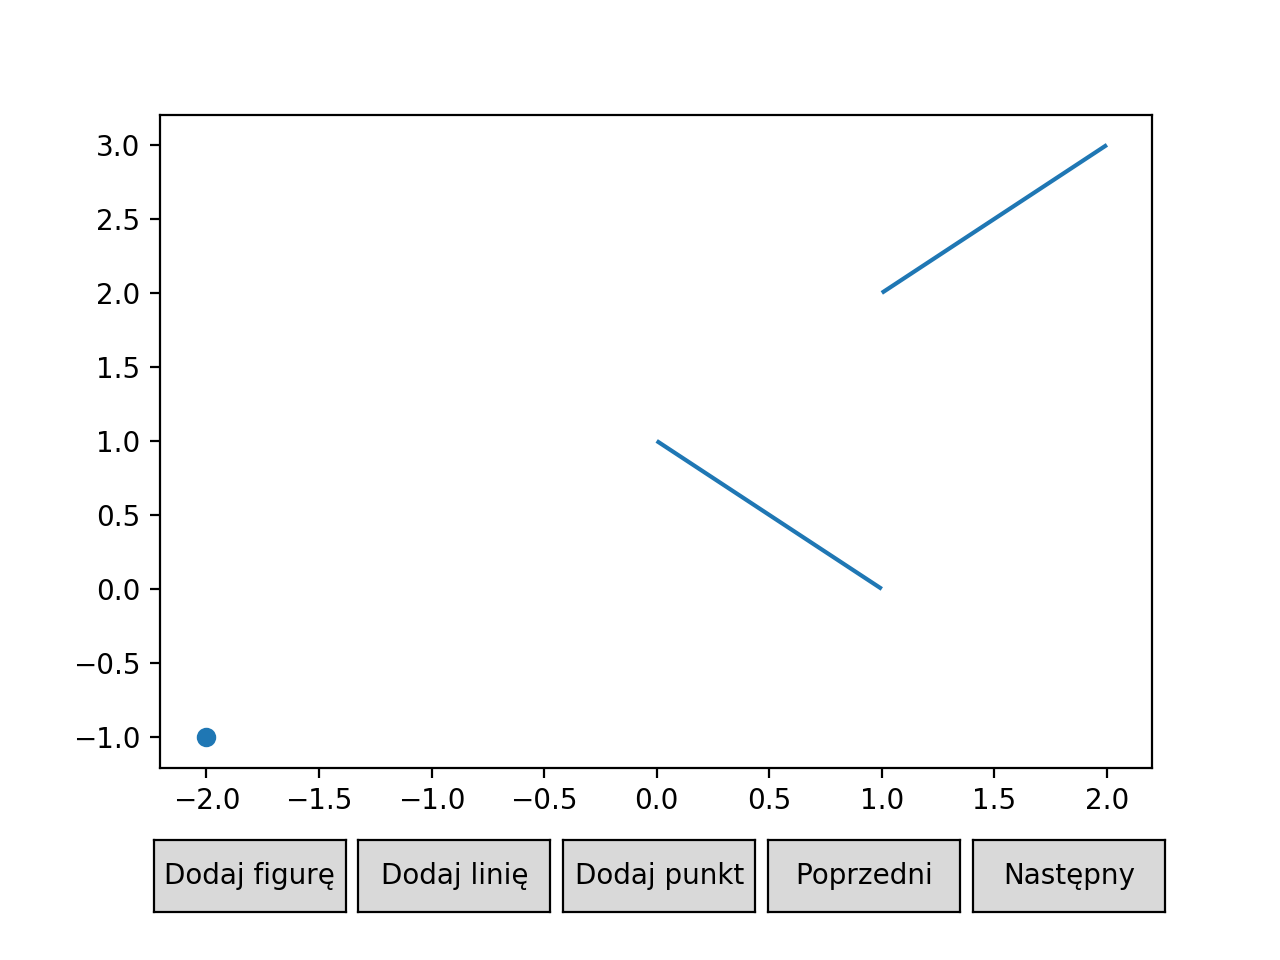

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


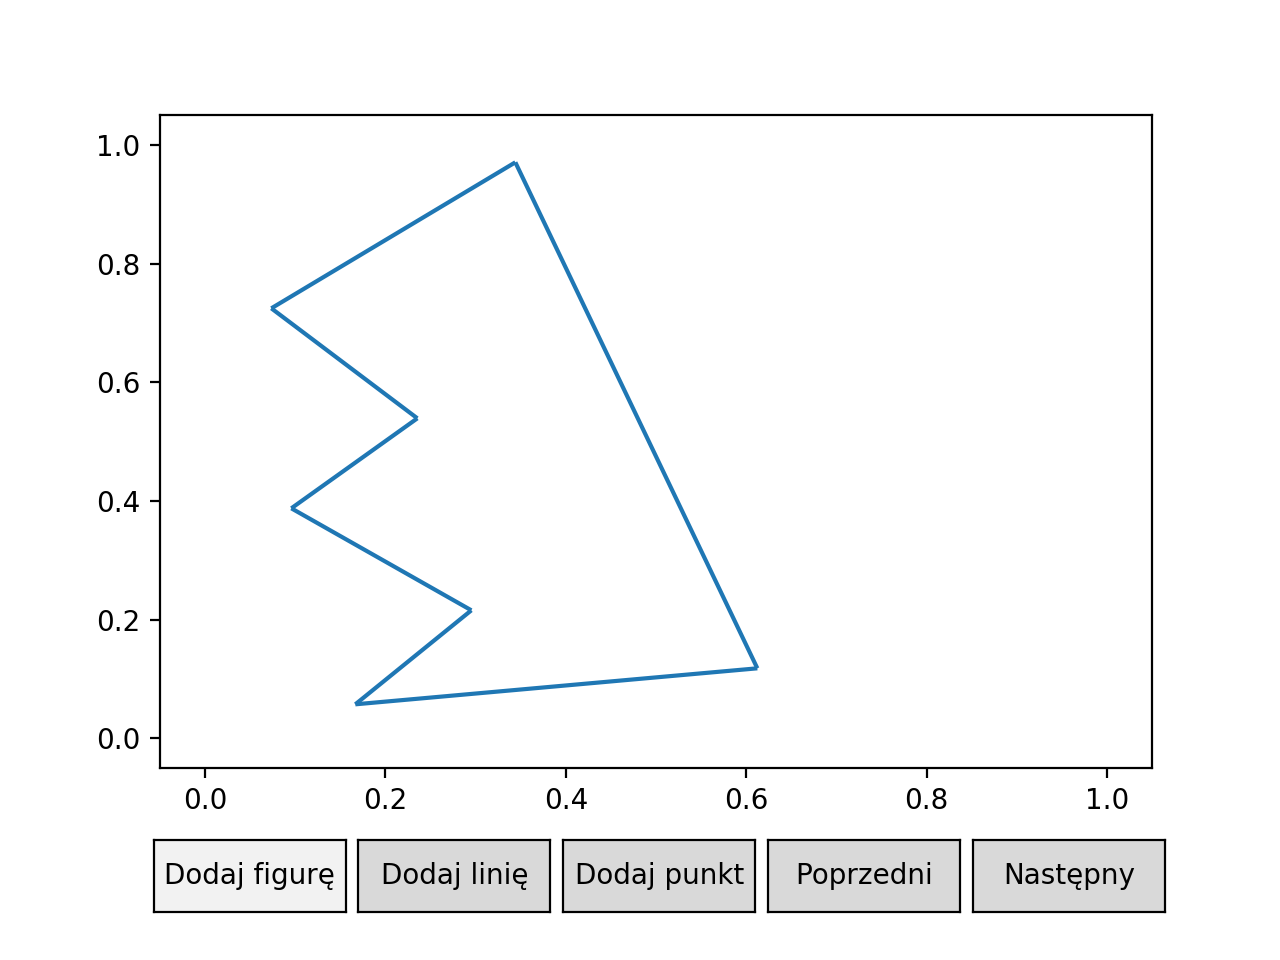

In [5]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


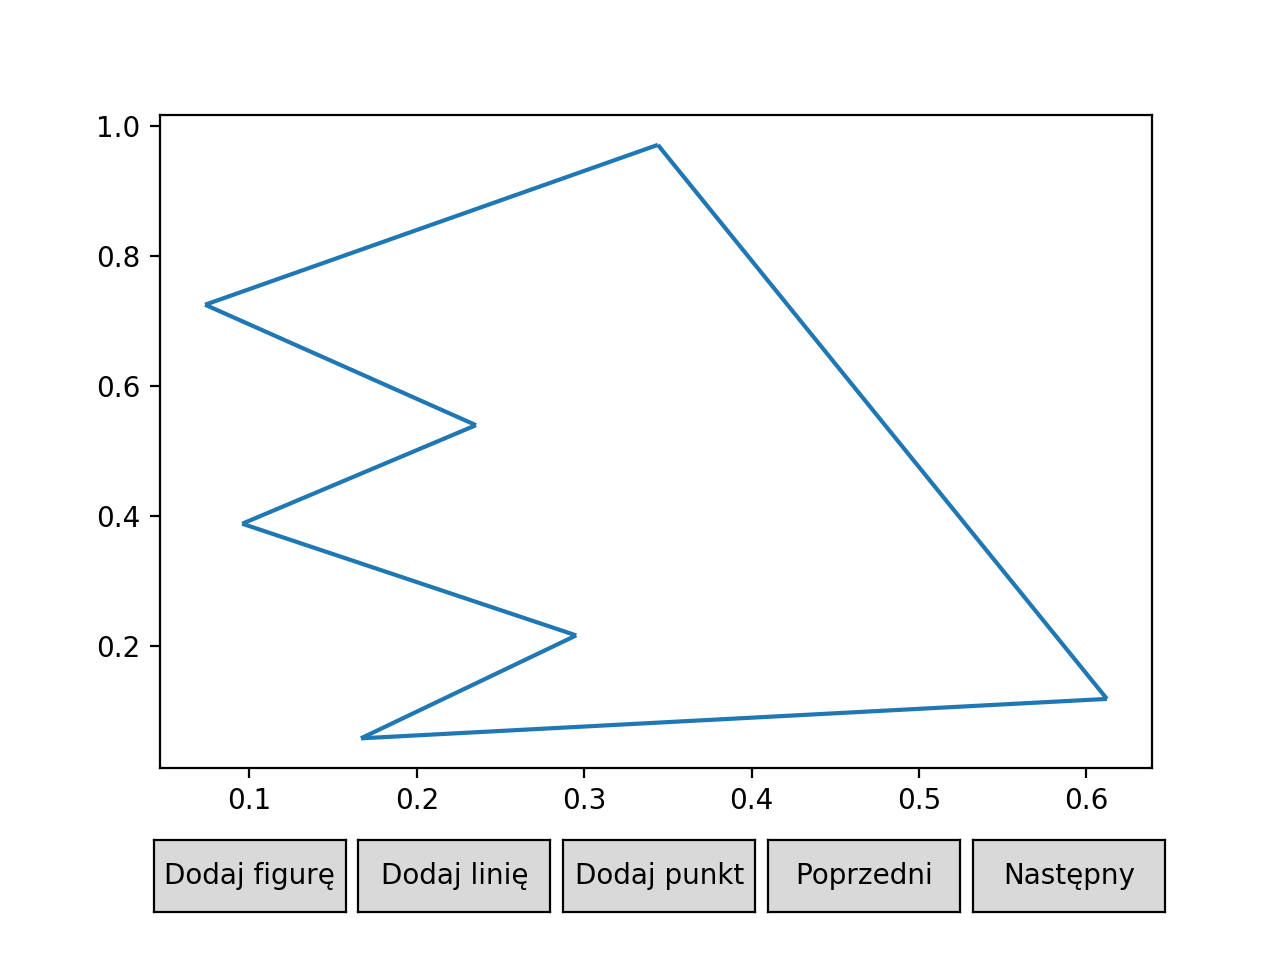

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [7]:
%matplotlib notebook
import enum

class Point_type(enum.Enum):
    start=1
    end=2
    merge=3
    split=4
    normal=5

In [8]:
# funkcja zwracająca krawedzie figury
def get_figure(figure):
    sides = []
    for f in figure:
        sides+=f.lines
    return sides 

In [9]:
def get_points(figure):
    sides=get_figure(figure)
    return( [i[1] for i in sides])

In [10]:
def det(p,q,r):
    return p[0]*q[1]+p[1]*r[0]+q[0]*r[1]-r[0]*q[1]-p[1]*q[0]-p[0]*r[1]

In [11]:
#funkcja klasyfikująca punkty figury
def classify(figure):
    verticies=get_points(figure)
    result = [0 for i in range(0, len(verticies))]
    
    for i in range(0, len(verticies)+2):
        idx=(i+1)%len(verticies)
        p=verticies[i%len(verticies)]
        q=verticies[(i+1)%len(verticies)]
        r=verticies[(i+2)%len(verticies)]
        
        determinant = det(p,q,r)
        
        if p[1]<q[1] and r[1]<q[1]:
            if determinant > 0 :
                result[idx]=Point_type.start
            else :
                result[idx]=Point_type.split
        elif p[1] > q[1] and r[1] > q[1]:
            if determinant >0 :
                result[idx]=Point_type.end
            else :
                result[idx]=Point_type.merge
        else: 
            result[idx]=Point_type.normal
           
    return result  

        

In [12]:
#funkcja sprawdzająca czy figura jest monotniczna 

def if_monotonous(figure):
    vertex_types=classify(figure)
    for i in vertex_types:
        if i==Point_type.split or i==Point_type.merge:
            return False
    return True
print(if_monotonous(plot1.get_added_figure()))

True


<IPython.core.display.Javascript object>


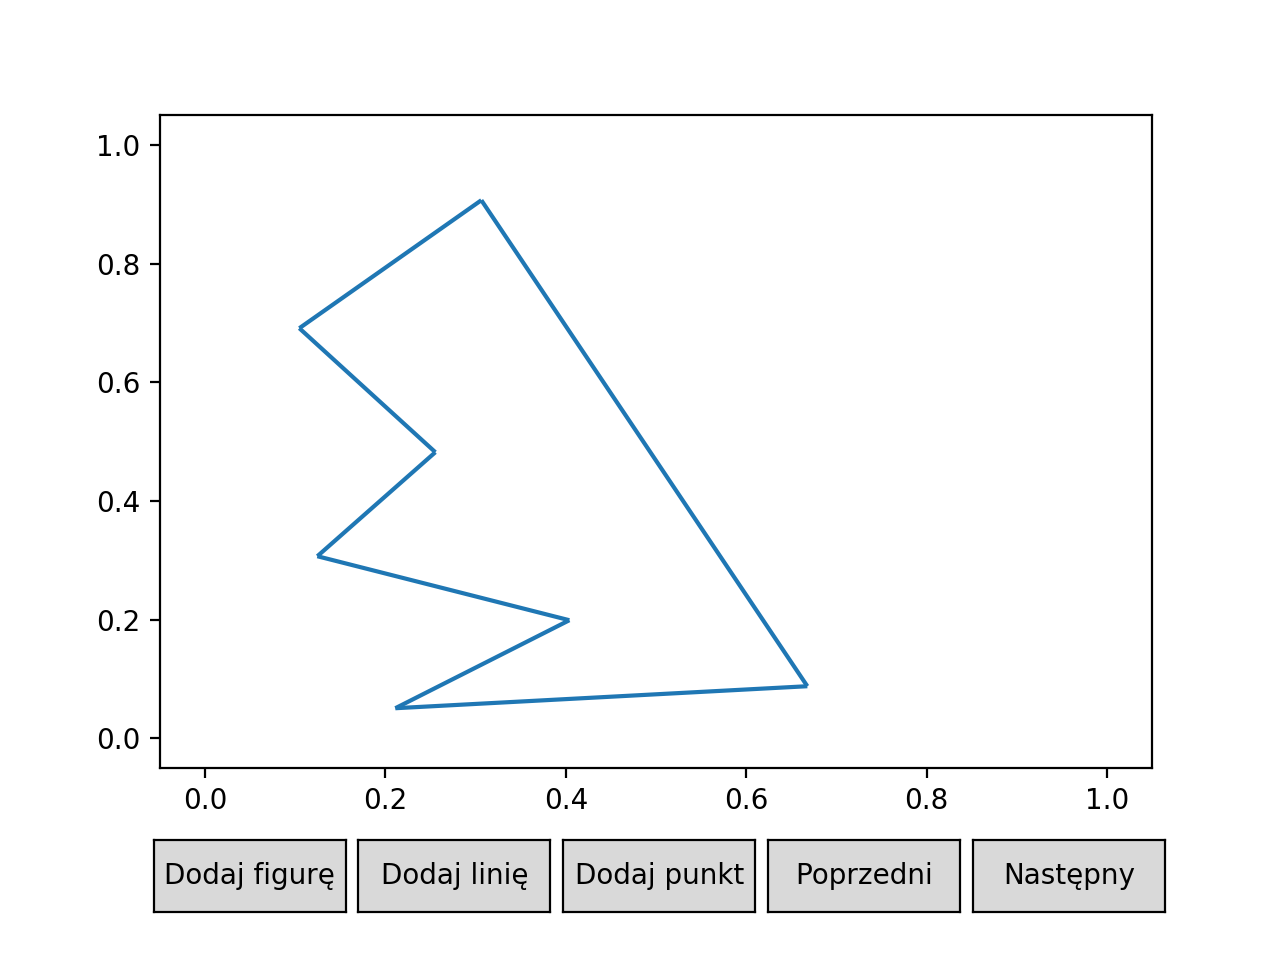

In [13]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

In [14]:
def Vizualization(figure):
    p=get_points(figure)
    verticies=classify(figure)
    greens=[]
    reds=[]
    darkblues=[]
    blues=[]
    browns=[]
    for v in range(0,len(verticies)):
        if verticies[v]==Point_type.start:
            greens.append(p[v])
        elif verticies[v]==Point_type.end:    
            reds.append(p[v])
        elif verticies[v]==Point_type.merge:
            darkblues.append(p[v])
        elif verticies[v] ==Point_type.split:
            blues.append(p[v])
        else :
            browns.append(p[v])
    l=get_figure(figure)        
    scenes=[Scene([PointsCollection(greens, color="green"), PointsCollection(reds,color="red"),\
                   PointsCollection(darkblues,color="darkblue"), PointsCollection(blues, color="lightblue"),\
                   PointsCollection(browns, color="black")], \
                 [LinesCollection(l,color="silver")])]
    return scenes

<IPython.core.display.Javascript object>


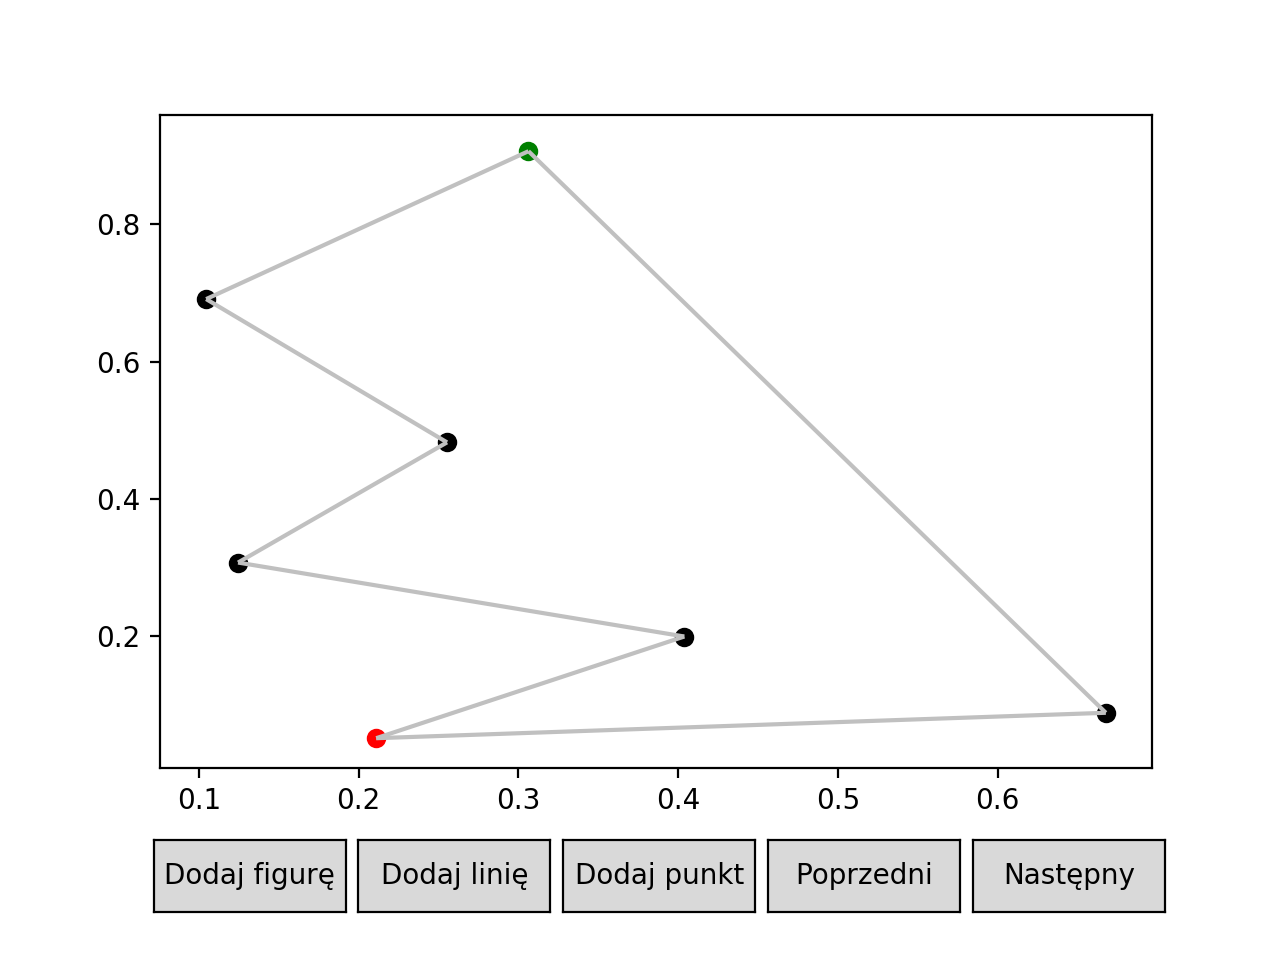

In [15]:
plotClassy=Plot(Vizualization(plot1.get_added_figure()))
plotClassy.draw()

In [23]:
print(if_monotonous(plot1.get_added_figure()))

True


In [16]:
#funkcja sprawdzająca czy krawędz należy do wielokąta
def check_interior(p,q,r):
    if p[1] == -1:
        return det (p[0],q[0],r[0]) >0
    else :
        return det (p[0],q[0],r[0] )< 0

In [17]:
#triangulacja"
def triangulation(figure):
    
    points_origin=get_points(figure)
    verticies=classify(figure)
    fig=get_figure(figure)
    start_idx=-1
    end_idx=-1
    for i in range(0,len(verticies)):
        if verticies[i]==Point_type.start:
            start_idx=i
        elif verticies[i]==Point_type.end:
            end_idx=i
            
    start_point=points_origin[start_idx]
    end_point=points_origin[end_idx]
    
    #tworzymy dwa łańcuchy, ozaczamy 1 lub -1 :
    
    points=[0 for i in range(len(points_origin))]
    for i in range(0,len(points_origin)):
        if i <= start_idx and i > end_idx:
            points[i]=((points_origin[i]), -1)
        else:
            points[i]=((points_origin[i]),1)
                
    #sortujemy wierzchołki
    
    points= sorted(points, key=lambda x : (x[0][1],x[0][0]), reverse = True) 
    
    stack = []
    stack.append(points[0])
    stack.append(points[1])
    
    i=2   
    result = []
    scenes=[]
    while i < (len(points)-1)  :
        
        top=stack[-1]
        p=points[i]        

        scenes.append(Scene([PointsCollection(points_origin)], \
                                     [ LinesCollection(fig),\
                                      LinesCollection(result)]))
        if p[1]!=top[1]:
        
            while len(stack) >1:
                tmp=stack.pop()

                result.append((p[0], tmp[0]))
                
            stack.pop()     
            stack.append(points[i-1])
            stack.append(points[i])
            
                
        else :
            tmp=stack.pop()
            if ( len(stack) >0 and check_interior(p,tmp,stack[-1]) ):

                result.append((p[0], stack[-1][0]))
                tmp=stack.pop()

            stack.append(tmp)
            stack.append(p)
        i+=1    
   
    return scenes    

<IPython.core.display.Javascript object>


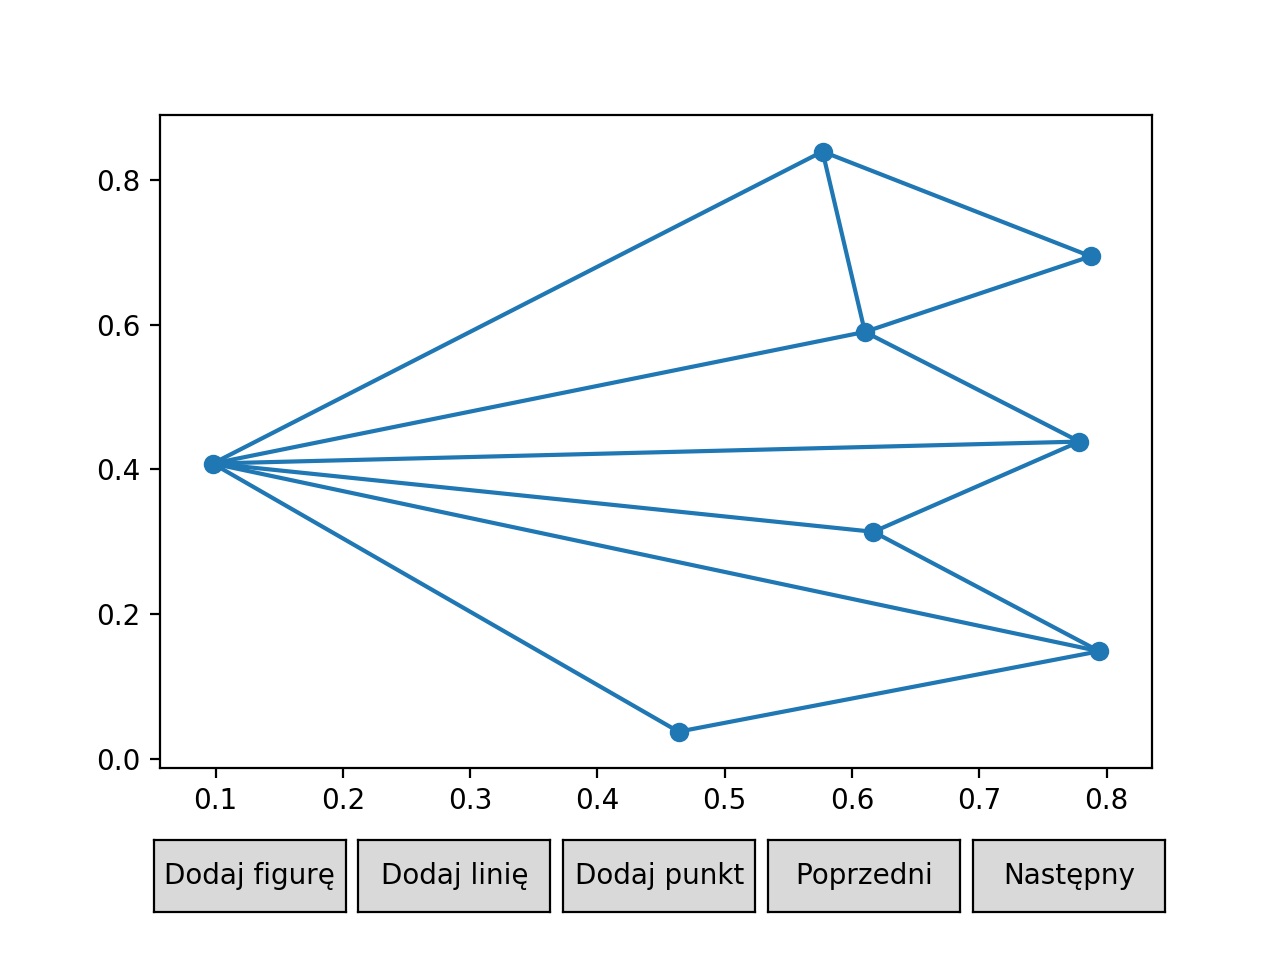

In [30]:
plotTrian=Plot(triangulation(plot1.get_added_figure()))
plotTrian.draw()

<IPython.core.display.Javascript object>


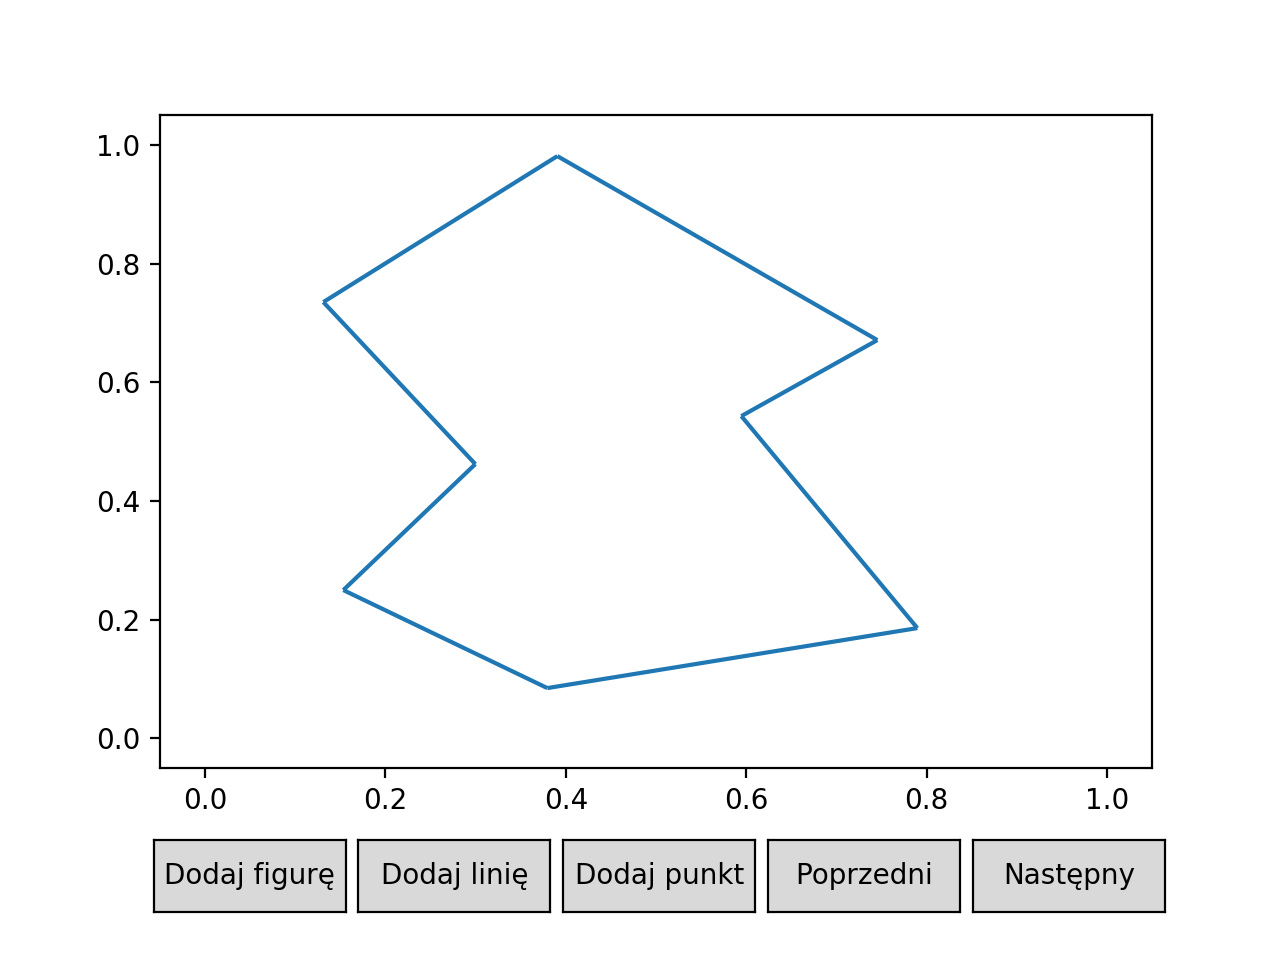

In [31]:
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


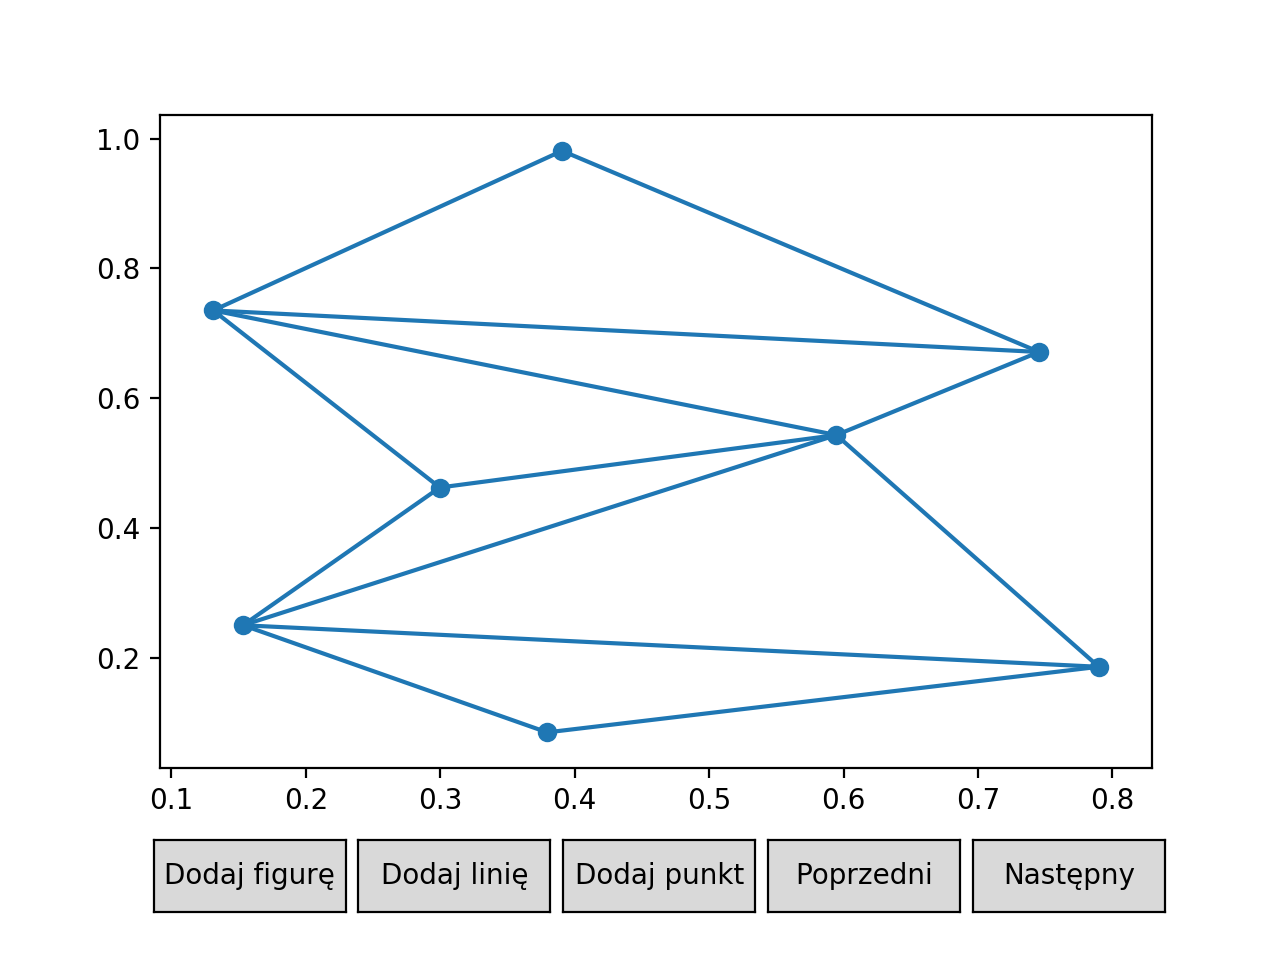

In [32]:
plotTrian=Plot(triangulation(plot1.get_added_figure()))
plotTrian.draw()

In [25]:
#triangulacja wielokąta "krok po kroku"
def triangulation_vis(figure):
    
    points_origin=get_points(figure)
    verticies=classify(figure)
    fig=get_figure(figure)
    start_idx=-1
    end_idx=-1
    for i in range(0,len(verticies)):
        if verticies[i]==Point_type.start:
            start_idx=i
        elif verticies[i]==Point_type.end:
            end_idx=i
            
    start_point=points_origin[start_idx]
    end_point=points_origin[end_idx]
    points=[0 for i in range(len(points_origin))]
    for i in range(0,len(points_origin)):
        if i <= start_idx and i > end_idx:
            points[i]=((points_origin[i]), -1)
        else:
            points[i]=((points_origin[i]),1)
                
            
    points= sorted(points, key=lambda x : (x[0][1],x[0][0]), reverse = True) 
    
    stack = []
    stack.append(points[0])
    stack.append(points[1])
    
    i=2   
    result = []

    scenes=[]
    #scenes = [Scene([PointsCollection(points_origin)], [LinesCollection(fig)])]
    while i < (len(points)-1)  :
        
        top=stack[-1]
        p=points[i]        

        scenes.append(Scene([PointsCollection(points_origin)], \
                                     [ LinesCollection(fig),\
                                      LinesCollection(list(result), color="hotpink")]))
        if p[1]!=top[1]:
        
            while len(stack) >1:
                tmp=stack.pop()
                result.append((p[0], tmp[0]))

                scenes.append(Scene([PointsCollection(points_origin)], \
                                    [ LinesCollection(fig),\
                                      LinesCollection(list(result), color="hotpink"),\
                                    ]))
                
                
            stack.pop()     
            stack.append(points[i-1])
            stack.append(points[i])
            
                
        else :
            tmp=stack.pop()
            if ( len(stack) >0 and check_interior(p,tmp,stack[-1]) ):

                
                scenes.append(Scene([PointsCollection(points_origin)], \
                                    [ LinesCollection(fig),\
                                    LinesCollection(list(result), color="hotpink"),\
                                    LinesCollection([[p[0], stack[-1][0]]], color="hotpink")]))
                result.append((p[0], stack[-1][0]))
                tmp=stack.pop()

            stack.append(tmp)
            stack.append(p)
        i+=1    
                
    scenes.append(Scene([PointsCollection(points_origin)], \
                                    [ LinesCollection(fig),\
                                    LinesCollection(list(result), color="hotpink"),\
                                    ]))    
    return scenes 

<IPython.core.display.Javascript object>


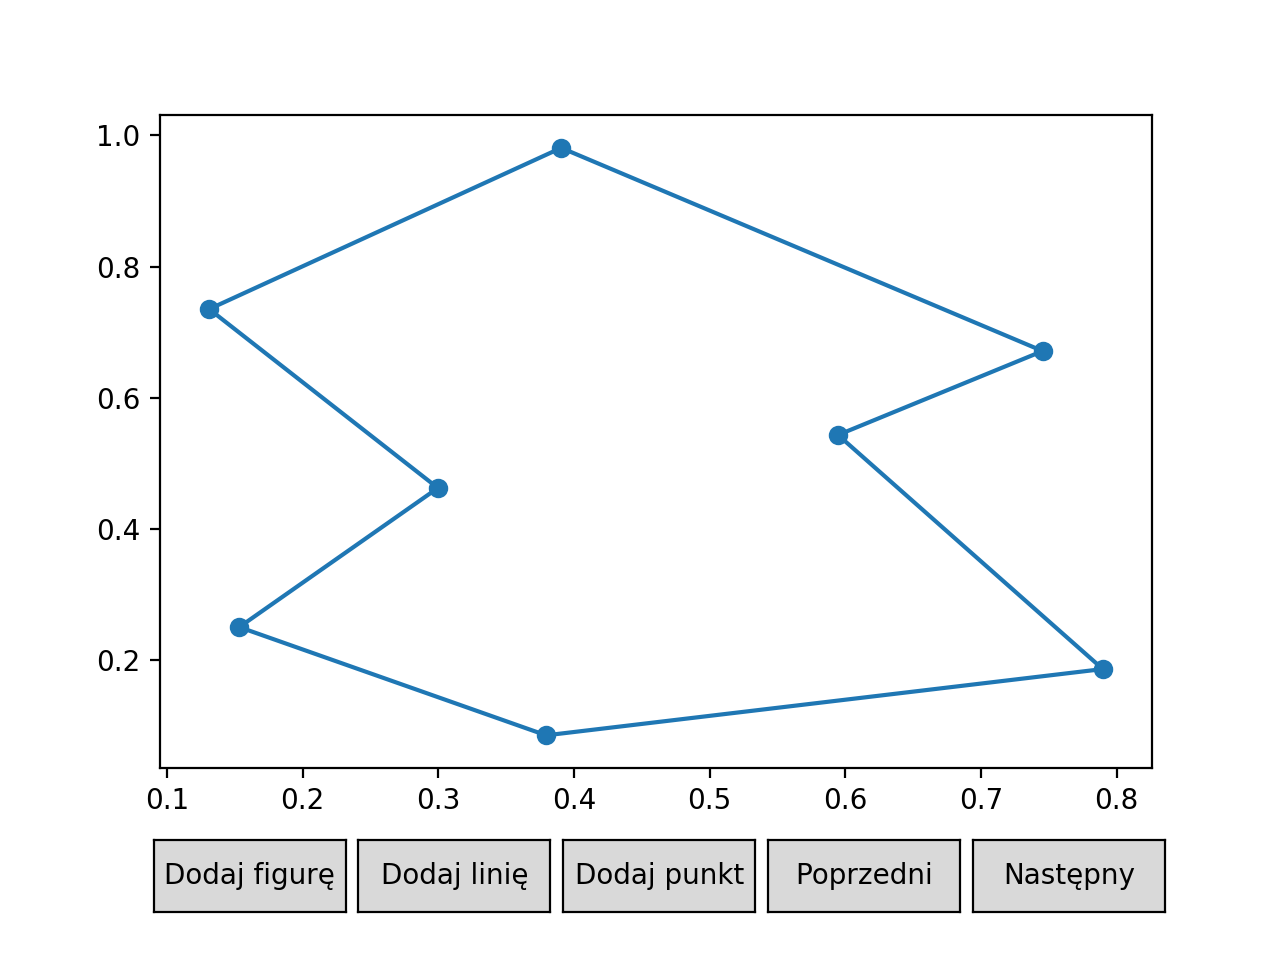

In [33]:
plotTrian=Plot(triangulation_vis(plot1.get_added_figure()))
plotTrian.draw()
